# Applying Convolutional Neural Networks to Cryptography for Digital Signing/Verification

### ABDUR REHMAN FA22-BCE-011

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import sys
import pickle


## Parameter Initialization

In [5]:
crypto_msg_len = N = 16
crypto_key_len = 16
batch_size = 512
epochs = 1 #50
learning_rate = 0.0008 #Optimizer learning rate

# Function to generate n random messages and keys
def gen_data(n=batch_size, msg_len=crypto_msg_len, key_len=crypto_key_len):
    #return (np.random.randint(0, 2, size=(n, msg_len))*2-1), (np.random.randint(0, 2, size=(n, key_len))*2-1)
    return (np.random.randint(0, 2, size=(n, msg_len))), (np.random.randint(0, 2, size=(n, key_len)))




In [3]:
def conv1d(input_, filter_shape, stride, name="conv1d"):
    with tf.compat.v1.variable_scope(name): # Changed tf.variable_scope to tf.compat.v1.variable_scope
        w = tf.compat.v1.get_variable('w', shape=filter_shape, initializer=tf.compat.v1.glorot_uniform_initializer()) # Updated initializer and get_variable
        conv = tf.nn.conv1d(input_, w, stride, padding='SAME')
        return conv

## Neural Cryptography Model definition

In [6]:
#If using TensorFlow 2.x, enable v1 compatibility:
tf.compat.v1.disable_eager_execution()

# Placeholder variables for Message and Key
msg = tf.compat.v1.placeholder("float", [None, crypto_msg_len])
key = tf.compat.v1.placeholder("float", [None, crypto_key_len])

# Weights for fully connected layers - using tf.compat.v1.get_variable for compatibility
with tf.compat.v1.variable_scope("weights", reuse=tf.compat.v1.AUTO_REUSE):  # Added variable scope with reuse
    w_alice = tf.compat.v1.get_variable("alice_w", shape=[2 * N, 2 * N], initializer=tf.compat.v1.glorot_uniform_initializer())
    w_bob = tf.compat.v1.get_variable("bob_w", shape=[2 * N, 2 * N], initializer=tf.compat.v1.glorot_uniform_initializer()) # Updated initializer for TF 1.x
    w_eve1 = tf.compat.v1.get_variable("eve_w1", shape=[N, 2 * N], initializer=tf.compat.v1.glorot_uniform_initializer()) # Updated initializer for TF 1.x
    w_eve2 = tf.compat.v1.get_variable("eve_w2", shape=[2 * N, 2 * N], initializer=tf.compat.v1.glorot_uniform_initializer()) # Updated initializer for TF 1.x

# Alice's Machine Network
# FC layer -> Conv Layer (4 1-D convolutions)
alice_input = tf.compat.v1.concat([msg, key], axis=1) # Changed tf.concat to tf.compat.v1.concat and using axis
alice_hidden = tf.nn.sigmoid(tf.matmul(alice_input, w_alice))
alice_hidden = tf.expand_dims(alice_hidden, 2)

h0 = tf.nn.relu(conv1d(alice_hidden, [4, 1, 2], stride=1, name="alice" + '_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2, 2, 4], stride=2, name="alice" + '_h1_conv'))
h2_alice = tf.nn.relu(conv1d(h1, [1, 4, 4], stride=1, name="alice" + '_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2_alice, [1, 4, 1], stride=1, name="alice" + '_h3_conv'))
alice_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Bob's Machine Network (gets the output (cipher text) of Alice's network)
# FC layer -> Conv Layer (4 1-D convolutions)
bob_input = tf.compat.v1.concat([msg, key], axis=1) # Changed tf.concat to tf.compat.v1.concat and using axis
bob_hidden = tf.nn.sigmoid(tf.matmul(bob_input, w_bob))
bob_hidden = tf.expand_dims(bob_hidden, 2)

h0 = tf.nn.relu(conv1d(bob_hidden, [4, 1, 2], stride=1, name="bob" + '_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2, 2, 4], stride=2, name="bob" + '_h1_conv'))
h2_bob = tf.nn.relu(conv1d(h1, [1, 4, 4], stride=1, name="bob" + '_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2_bob, [1, 4, 1], stride=1, name="bob" + '_h3_conv'))
bob_output = tf.squeeze(h3) # eliminate dimensions of size 1 from the shape of a tensor

# Eve's Machine Network
# FC layer -> FC layer -> Conv Layer (4 1-D convolutions)
eve_input = alice_output
eve_hidden1 = tf.nn.sigmoid(tf.matmul(eve_input, w_eve1))
eve_hidden2 = tf.nn.sigmoid(tf.matmul(eve_hidden1, w_eve2))
eve_hidden2 = tf.expand_dims(eve_hidden2, 2)

h0 = tf.nn.relu(conv1d(eve_hidden2, [4, 1, 2], stride=1, name="eve" + '_h0_conv'))
h1 = tf.nn.relu(conv1d(h0, [2, 2, 4], stride=2, name="eve" + '_h1_conv'))
h2 = tf.nn.relu(conv1d(h1, [1, 4, 4], stride=1, name="eve" + '_h2_conv'))
h3 = tf.nn.tanh(conv1d(h2, [1, 4, 1], stride=1, name="eve" + '_h3_conv'))
eve_output = tf.squeeze(h3)

## Neural Cryptography Training

In [18]:
alice_errors, bob_errors, eve_errors = [], [], []

# Loss Functions
decrypt_err_eve = tf.reduce_mean(tf.abs(msg - eve_output))
decrypt_err_alice = tf.reduce_mean(tf.abs(msg - alice_output))
loss_alice = decrypt_err_alice + (1. - decrypt_err_eve) ** 2.
decrypt_err_bob = tf.reduce_mean(tf.abs(msg - bob_output))
loss_bob = decrypt_err_bob + (1. - decrypt_err_eve) ** 2.

# Get training variables corresponding to each network
t_vars = tf.compat.v1.trainable_variables() # Use tf.compat.v1.trainable_variables() for TF 1.x compatibility
alice_vars = [var for var in t_vars if 'alice_' in var.name]
bob_vars =   [var for var in t_vars if 'bob_' in var.name]
eve_vars =   [var for var in t_vars if 'eve_' in var.name]

# Build the optimizers, can play with different optimizers

'''
alice_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1,
                       use_locking=False, name='Adagrad').minimize(loss_alice, var_list=alice_vars)
bob_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1,
                        use_locking=False, name='Adagrad').minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.AdagradOptimizer(learning_rate, initial_accumulator_value=0.1,
                        use_locking=False, name='Adagrad').minimize(decrypt_err_eve, var_list=eve_vars)

alice_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_alice, var_list=alice_vars)
bob_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.train.MomentumOptimizer(0.01, 0.9).minimize(decrypt_err_eve, var_list=eve_vars)

'''
# Use tf.compat.v1.train.AdamOptimizer for TensorFlow 1.x compatibility
alice_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_alice, var_list=alice_vars)
bob_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_bob, var_list=bob_vars)
eve_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(decrypt_err_eve, var_list=eve_vars)

def train(sess):
    # Begin Training
    #tf.initialize_all_variables().run(session=sess)
    sess.run(tf.compat.v1.global_variables_initializer()) # Use tf.compat.v1.global_variables_initializer() and sess.run()
    for i in range(epochs):
        iterations = 2000

        alice_loss, _, _ = _train('alice', iterations, sess)
        alice_errors.append(alice_loss)
        print( 'Training Alice, Epoch:', i + 1, ' error: ', alice_loss)

        _, bob_loss, _ = _train('bob', iterations, sess)
        bob_errors.append(bob_loss)
        print( 'Training Bob, Epoch:', i + 1, ' error: ', bob_loss)

        _, _, eve_loss = _train('eve', iterations, sess)
        eve_errors.append(eve_loss)
        print( 'Training Eve, Epoch:', i + 1, ' error: ', eve_loss)


def _train(network, iterations, sess):
    alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.

    bs = batch_size
    # Train Eve for two minibatches to give it a slight computational edge
    if network == 'eve':
        bs *= 2

    for i in range(iterations):
        msg_in_val, key_val = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        feed_dict={msg: msg_in_val, key: key_val}
        if network == 'alice':
            _, decrypt_err = sess.run([alice_optimizer, decrypt_err_alice], feed_dict = feed_dict)
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
        elif network == 'bob':
            _, decrypt_err = sess.run([bob_optimizer, decrypt_err_bob], feed_dict = feed_dict)
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

    return alice_decrypt_error, bob_decrypt_error, eve_decrypt_error


## Neural Cryptography Testing Helper Functions

This section of the code takes input and prepares it for the socket communication

In [21]:
text = input('Enter some text: ')
bintext = ' '.join('{0:08b}'.format(ord(x), 'b') for x in text)
print (bintext)
b1  = bintext.replace(" ", "")
#b1 = b1.zfill(48)
pad = len(b1)%16

v1 = np.array([])
for i in range(0, len(b1)):
    v1 = np.append(v1, int(b1[i]))

#apply the padding
for i in range(0, pad):
    v1 = np.append(v1, int(0))
total_len = len(b1) + pad

plaintext_to_Alice = v1.reshape(int(total_len/16), 16)
print('plaintext_to_Alice = ', plaintext_to_Alice)

Enter some text: Hi Alice What's good hows ur day!
01001000 01101001 00100000 01000001 01101100 01101001 01100011 01100101 00100000 01010111 01101000 01100001 01110100 00100111 01110011 00100000 01100111 01101111 01101111 01100100 00100000 01101000 01101111 01110111 01110011 00100000 01110101 01110010 00100000 01100100 01100001 01111001 00100001
plaintext_to_Alice =  [[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0. 0

## Socket Communication

We are sending the message as Alice to Bob

In [24]:
def sock_send(message):
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_address = ('localhost', 10000)
    sock.connect(server_address)
    #To send data over network, you need to serialize it into an array of bytes,
    #then deserialize it back. In Python, serialization of most objects can be done via pickle module:
    print('message = ', message)
    msg2 = pickle.dumps(message)
    #print('msg2 = ', msg2)
    sock.send(msg2)

In [25]:

def sock_recv_init():
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    # Bind the socket to the port
    address = ('localhost', 10000)
    print('starting up on %s port %s' % address)
    sock.bind(address)
    # Listen for incoming connections
    sock.listen(1)
    return sock

def sock_recv(sock):
    # Wait for a connection
    print( 'waiting for a connection')
    connection, client_address = sock.accept()
    print('connection from', client_address)
    # Receive the data (max 48 bytes)
    data = connection.recv(1024*10)
    #print('received "%s"' % data)
    data1 = pickle.loads(data)
    print('received ', data1)
    return data1

sock = sock_recv_init()


starting up on localhost port 10000


In [26]:

test_file_msg = "testmsg.txt"
test_file_keys = "testkey.txt"
alice_output_sign = 0

def test(network, sess):
        alice_decrypt_error, bob_decrypt_error, eve_decrypt_error = 1., 1., 1.
        alice_encrypt_time = 0
        bob_decrypt_time = 0
        bob_output_1 = 0
        alice_h2_conv_1 = 0
        bob_h2_conv_1 = 0
        #bs = 3 #batch_size
        bs = int(total_len/16) #batch_size
        messages, keys = gen_data(n=bs, msg_len=crypto_msg_len, key_len=crypto_key_len)
        #test message to get the code complete
        messages = np.array([
                    [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
                    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
                    [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
                   ])


        #feed_dict={msg: messages, key: keys}
        feed_dict={msg: plaintext_to_Alice, key: keys}

        print( 'messages = \n', plaintext_to_Alice)
        print( 'keys = \n', keys)

        if network == 'alice':
            print('plaintext_to_Alice = ', plaintext_to_Alice)
            start_time = time.time()
            _, decrypt_err, alice_output_1, alice_h2_conv_1  = sess.run([alice_optimizer, decrypt_err_alice, alice_output, alice_hidden], feed_dict = feed_dict)
            end_time = time.time()
            alice_encrypt_time = end_time-start_time
            global alice_output_sign
            alice_output_sign = alice_output_1
            print('test alice_output (Signature) = \n', alice_output_1)
            alice_decrypt_error = min(alice_decrypt_error, decrypt_err)
            print('SOCK_SEND')
            sock_send(alice_output_1)
        elif network == 'bob':
            print('SOCKET_RECV ==== \n')
            messages_sock = sock_recv(sock)
            print(messages_sock)
            feed_dict1 = {msg: messages_sock, key: keys}
            start_time = time.time()
            _, decrypt_err, bob_input_1, bob_output_1, bob_h2_conv_1 = sess.run([bob_optimizer, decrypt_err_bob, bob_input, bob_output, bob_hidden], feed_dict = feed_dict1)
            end_time = time.time()
            bob_decrypt_time = end_time-start_time
            bob_input_1 = np.round(bob_input_1, 2)
            bob_ouput_1 = np.round(bob_output_1, 2)

            print('test bob_input = \n', bob_input_1)
            print('test bob_output = \n',  bob_output_1)
            bob_decrypt_error = min(bob_decrypt_error, decrypt_err)
        elif network == 'eve':
            _, decrypt_err = sess.run([eve_optimizer, decrypt_err_eve], feed_dict = feed_dict)
            eve_decrypt_error = min(eve_decrypt_error, decrypt_err)

        return alice_decrypt_error, alice_encrypt_time, alice_h2_conv_1, bob_decrypt_error, bob_decrypt_time, bob_output_1, bob_h2_conv_1, eve_decrypt_error

In [14]:


%matplotlib inline

def plot_results():
    """
    Plot Lowest Errors achieved by Alice, Bob, and Eve per epoch
    """
    sns.set_style("darkgrid")
    plt.plot(alice_errors)
    plt.plot(bob_errors)
    plt.plot(eve_errors)
    plt.legend(['alice', 'bob', 'eve'])
    plt.xlabel('Epoch')
    plt.ylabel('Lowest error achieved')
    plt.show()

# TensorFlow Session

## Training

Starting Training Process... 
Training Alice, Epoch: 1  error:  0.0005021254
Training Bob, Epoch: 1  error:  0.00026928776
Training Eve, Epoch: 1  error:  0.3349837
Training Alice, Epoch: 2  error:  0.0005860837
Training Bob, Epoch: 2  error:  3.727947e-05
Training Eve, Epoch: 2  error:  0.33360314
Training Alice, Epoch: 3  error:  0.0016419843
Training Bob, Epoch: 3  error:  9.530711e-06
Training Eve, Epoch: 3  error:  0.3334459
Training Alice, Epoch: 4  error:  0.034017053
Training Bob, Epoch: 4  error:  3.1218005e-06
Training Eve, Epoch: 4  error:  0.34765533
Training Alice, Epoch: 5  error:  0.01999372
Training Bob, Epoch: 5  error:  8.494608e-07
Training Eve, Epoch: 5  error:  0.3767656
Training Alice, Epoch: 6  error:  0.0008766799
Training Bob, Epoch: 6  error:  2.4515612e-07
Training Eve, Epoch: 6  error:  0.33264187
Training Alice, Epoch: 7  error:  4.196424e-06
Training Bob, Epoch: 7  error:  8.291681e-08
Training Eve, Epoch: 7  error:  0.33294684
Training Alice, Epoch: 8  er

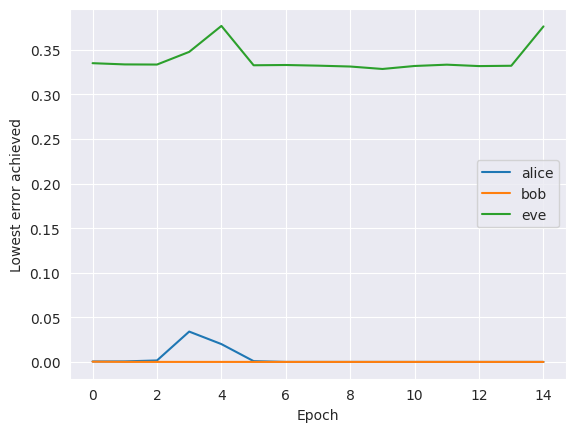

alice_errors_train =  [0.0005021254, 0.0005860837, 0.0016419843, 0.034017053, 0.01999372, 0.0008766799, 4.196424e-06, 1.563657e-06, 3.1315852e-07, 9.4500336e-08, 3.8130587e-08, 2.3049758e-08, 7.94697e-09, 5.3230558e-09, 4.015204e-09]
bob_errors_train =  [0.00026928776, 3.727947e-05, 9.530711e-06, 3.1218005e-06, 8.494608e-07, 2.4515612e-07, 8.291681e-08, 2.6862836e-08, 9.487849e-09, 3.5070116e-09, 9.895302e-10, 3.783498e-10, 0.0, 0.0, 0.0]
eve_errors_train =  [0.3349837, 0.33360314, 0.3334459, 0.34765533, 0.3767656, 0.33264187, 0.33294684, 0.33221436, 0.3312378, 0.3284912, 0.33184814, 0.333313, 0.33172613, 0.3320923, 0.3762207]


In [19]:
import time
import tensorflow as tf

# If using TensorFlow 2.x, enable v1 compatibility:
tf.compat.v1.disable_eager_execution()

epochs = 15
# Use tf.compat.v1.Session for TensorFlow 1.x compatibility
sess = tf.compat.v1.Session()

#with tf.Session() as sess:
print('Starting Training Process... ')
start_time = time.time()
train(sess)
end_time = time.time()
print('Time taken for Training (seconds): ', end_time-start_time)
plot_results()

print('alice_errors_train = ', alice_errors)
print('bob_errors_train = ', bob_errors)
print('eve_errors_train = ', eve_errors)


## Testing

The above section of the code for training the CNN does not have to be rerun if the user decides to input another message.

In [20]:
import binascii
def stringize(data):
    b1_temp = np.rint(data)
    b1_temp = b1_temp.ravel();
    b1_temp = np.abs(b1_temp)
    b2_temp  = np.array2string(b1_temp)
    b2_temp = b2_temp.strip('[')
    b2_temp = b2_temp.strip(']')
    b2_temp = b2_temp.replace(" ", "")
    b2_temp = b2_temp.replace(".", "")
    b2_temp = b2_temp.replace("\n", "")
    print('\tBinary = ',  b2_temp)
    s1 =  ''.join([ "%x"%int(bin,2) for bin in b2_temp.split() ])
    #Pad for SHA256 (32 Bytes = 64 digits)
    s1 = s1.zfill(64)

    return s1

#Test the Neural Crypto model
start_time = time.time()
print( 'Testing Alice' )
alice_loss_test, alice_sign_time, alice_h2_conv_1,_,_, _, _,_ = test('alice', sess)
print('alice_errors_test = ', alice_loss_test)
print( 'Testing Bob' )
_,_,_,bob_loss_test, bob_sign_time, bob_output_1,bob_h2_conv_1,_ = test('bob', sess)
print('bob_errors_test = ', bob_loss_test)
print( 'Testing Eve' )
_, _,_,_,_,_,_,eve_loss_test = test('eve', sess)
print('eve_errors_test = ', eve_loss_test)
end_time = time.time()
print('Time taken for Testing (seconds): ', end_time-start_time)

#print('alice_output_sign=', alice_output_sign)
print('Alice Computed Signature*********')
alice_sign = stringize(alice_output_sign)
print('\tHex = ', alice_sign)
print('Bob Computed Signature*********')
bob_sign = stringize(bob_output_1)
print('\tHex = ', bob_sign)

if (alice_sign == bob_sign):
    print('Alice and Bob Signature (32 bytes) Verification SUCCESS!')
else:
    print('Alice and Bob Signature (32 bytes) Verification ERROR')


Testing Alice
messages = 
 [[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.]]
keys = 
 [[0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0]
 [0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1]
 [1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0]
 [1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1]]
plaintext_to_Alice =  [[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.]]
test alice_output (Signature) = 
 [[ 0.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  1.0000000e+00  1.0000000e+00  0.0000000e+00
   1.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00

# Conclusion

In this notebook, I have demonstrated the unique capability of neural networks to ensure integrity and authenticity through digital signatures comparable to SHA256.

Future work also includes implementing the sockets over Internet Protocol, instead of localhost. In addition, other goals include implementing Eve and her socket as part of the crypto-pipeline and transmitting signatures appended to the plaintext across the sockets. It would also be interesting to inspect if Eve is able to compute the signature of a plaintext message through the Eve_Hidden layer and reach similar results as Bob and Alice.

